In [ ]:
from google.colab import drive
drive.mount('./mount')

Mounted at ./mount


In [ ]:
import torch
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla T4


device(type='cuda')

In [ ]:
import pandas as pd
import torch
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import numpy as np

class MnistDataset(Dataset):
    train_data = pd.read_csv("./mount/My Drive/Colab Notebooks/firstGAN/mnist_train.csv")
    train_data =train_data.to_numpy()
    # read csv
    def __init__(self):
        super().__init__()
        
    def __len__(self):
        return len(MnistDataset.train_data)
    def __getitem__(self, index):
        #return torch.tensor(MnistDataset.train_data[index,1:]/255,dtype=torch.float32)
        return torch.cuda.FloatTensor(MnistDataset.train_data[index,1:]/255.0)

    def plot_image(self,n):
        data = MnistDataset.train_data[n,1:].reshape(28,28)
        plt.figure(figsize=(3,3))
        plt.imshow(data)



In [ ]:
mnist_dataset = MnistDataset()


In [ ]:
from torch.optim import SGD,Adam
from torch.nn import MSELoss,BCELoss

class D(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Linear(784,200),
            torch.nn.LeakyReLU(0.02),
            torch.nn.LayerNorm(200),
            torch.nn.Linear(200,1),
            torch.nn.Sigmoid(),
        )
        self.optimizer = Adam(self.parameters(),lr=0.0001)
        self.loss_fn = BCELoss()
        self.loss_hist = []
    
    def forward(self,x):
        return self.model(x)

    def train(self,x,label):
        self.optimizer.zero_grad()
        y_pred = self.model(x)
        loss = self.loss_fn(y_pred,label)
        loss.backward()
        self.optimizer.step()

        self.loss_hist.append(loss.item())
    
    def visualize(self):
        plt.figure(figsize=(12,4))
        plt.scatter(np.arange(1,len(self.loss_hist)+1),self.loss_hist,s=0.5)
        plt.title('discriminator loss')
        plt.show()    
        


In [ ]:
def gen_random(size):
    return torch.randn(size)


In [ ]:
class G(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Linear(100,200),
            torch.nn.LeakyReLU(0.02),
            torch.nn.LayerNorm(200),
            torch.nn.Linear(200,784),
            torch.nn.Sigmoid(),
        )

        self.optimizer = Adam(self.parameters(),lr=0.0001)
        
        self.loss_hist = []

    def forward(self,x):
        return self.model(x)
    
    def train(self,D,x,label):
        self.optimizer.zero_grad()
        fake_pred = self.forward(x)
        y_pred = D(fake_pred)
        loss = D.loss_fn(y_pred,label)
        loss.backward()
        self.optimizer.step()
        
        self.loss_hist.append(loss.item())
    
    def visualize(self):
        plt.figure(figsize=(12,4))
        plt.scatter(np.arange(1,len(self.loss_hist)+1),self.loss_hist,s=0.5)
        plt.title('generator loss')
        plt.show()
    
    def visualize_8img(self,x):
        #fake_pred = self.forward(x).detach().numpy() # size(16,28*28)
        fake_pred = self.forward(x).detach().cpu().numpy() # size(16,28*28)
        fake_pred = fake_pred.reshape((-1,28,28)).transpose((1,0,2)).reshape((28,-1))

        plt.figure(figsize=(16,2))
        plt.title('generator prediction')
        plt.imshow(fake_pred, cmap='Blues')
        

In [ ]:
%%time

dataloader = DataLoader(mnist_dataset,1)
d = D()
d.to(device)
g= G()
g.to(device)

epochs=4
for epoch in range(epochs):
    for i,data in enumerate(dataloader): #enumerate 가능한가? 몇 epoch인지 출력하고 싶은데


        d.train(data.reshape(784),torch.cuda.FloatTensor([1.0]))
        d.train(g(gen_random(100)).detach(),torch.cuda.FloatTensor([0.0]))
        g.train(d,gen_random(100),torch.cuda.FloatTensor([1.0]))

        if i%(100)==0:
            print(f"i {i}")   
            if (d.loss_hist):
                print(f'g loss {g.loss_hist[-1]}')
                print(f'd loss {d.loss_hist[-1]}')

i 0
g loss 0.2193939983844757
d loss 2.037111520767212
i 100
g loss 5.675271034240723
d loss 0.003478311002254486
i 200
g loss 6.797373294830322
d loss 0.0013678483664989471
i 300
g loss 6.371458053588867
d loss 0.0013243380235508084
i 400
g loss 6.690338611602783
d loss 0.0008197805727832019
i 500
g loss 7.13944673538208
d loss 0.0006336789228953421
i 600
g loss 8.036181449890137
d loss 0.0012458572164177895
i 700
g loss 8.234668731689453
d loss 0.0008617775747552514
i 800
g loss 7.231052875518799
d loss 0.0003944817290175706
i 900
g loss 7.867000579833984
d loss 0.00035357766319066286
i 1000
g loss 8.262287139892578
d loss 0.0003353323554620147
i 1100
g loss 8.544672966003418
d loss 0.0008153065573424101
i 1200
g loss 7.273928165435791
d loss 0.00023534682986792177
i 1300
g loss 7.099775314331055
d loss 0.00019331654766574502
i 1400
g loss 7.977723121643066
d loss 0.0012762342812493443
i 1500
g loss 7.539377689361572
d loss 0.0005425494164228439
i 1600
g loss 7.804563522338867
d loss

KeyboardInterrupt: ignored

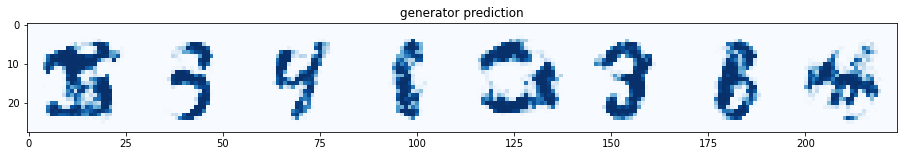

In [ ]:
g.visualize_8img(gen_random((8,100)))

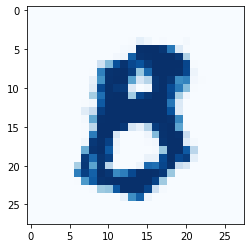

In [ ]:
seed1 = gen_random(100)
out1 = g.forward(seed1)
img1 = out1.detach().cpu().numpy().reshape(28,28)
plt.imshow(img1, interpolation='none', cmap='Blues')

tensor([0.0912], grad_fn=<SigmoidBackward0>)


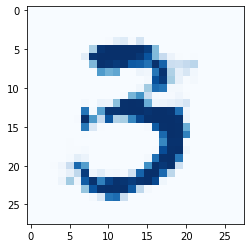

In [ ]:
seed2 = gen_random(100)
out2 = g.forward(seed2)
print(d(out2.detach()))
img2 = out2.detach().cpu().numpy().reshape(28,28)
plt.imshow(img2, interpolation='none', cmap='Blues')

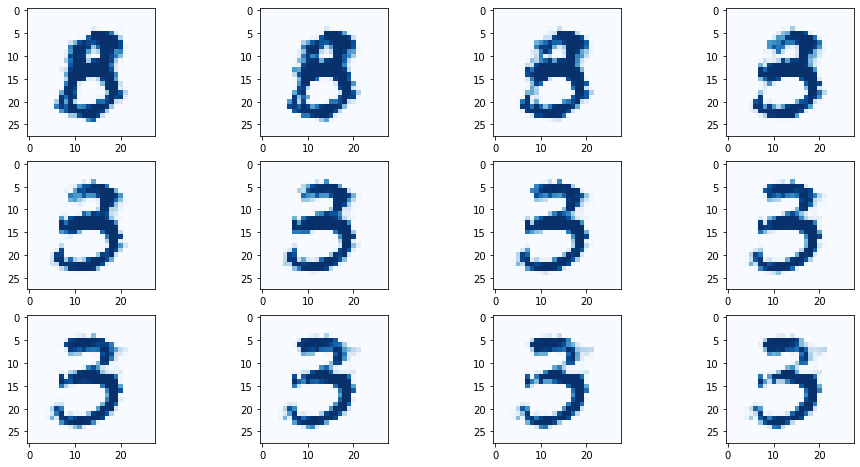

In [ ]:
count = 0

# plot a 3 column, 2 row array of generated images
f, axarr = plt.subplots(3,4, figsize=(16,8))
for i in range(3):
    for j in range(4):
        seed = seed1 + (seed2 - seed1)/11 * count
        output = g.forward(seed)
        img = output.detach().cpu().numpy().reshape(28,28)
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        count = count + 1
        pass
    pass

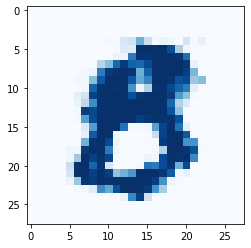

In [ ]:
seed3 = 10*seed1 + seed1
out3 = g.forward(seed3)
img3 = out3.detach().cpu().numpy().reshape(28,28)
plt.imshow(img3, interpolation='none', cmap='Blues')

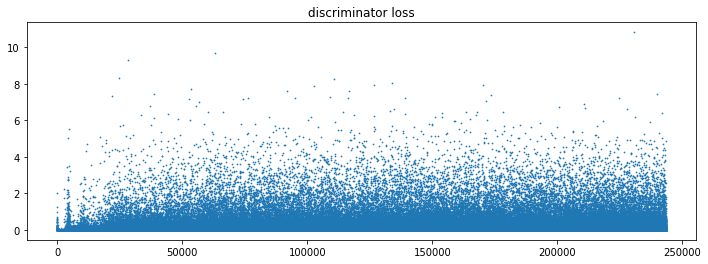

In [ ]:
d.visualize()

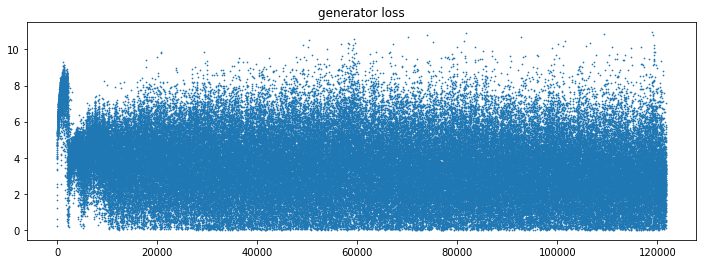

In [ ]:
g.visualize()

In [ ]:
torch.cuda.memory_allocated(device) / (1024*1024*1024)

0.005026817321777344

In [ ]:
torch.cuda.max_memory_allocated(device) / (1024*1024*1024)

0.006206512451171875

In [ ]:
print(torch.cuda.memory_summary(device, abbreviated=True))

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |    3879 KB |    6508 KB |  379628 MB |  379624 MB |
|---------------------------------------------------------------------------|
| Active memory         |    3879 KB |    6508 KB |  379628 MB |  379624 MB |
|---------------------------------------------------------------------------|
| GPU reserved memory   |    8192 KB |    8192 KB |    8192 KB |       0 B  |
|---------------------------------------------------------------